In [2]:
import numpy as np
import pandas as pd
import pyswarms as ps
from collections import defaultdict
import matplotlib.pyplot as plt


class QLearningAgent:
    def __init__(self, actions, learning_rate=0.02, discount_factor=0.95, exploration_rate=0.25):
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate

    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.randint(len(self.actions))  # Asegurarse de devolver un índice entero
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error


In [3]:
# Parámetros PSO
c1_actions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
c2_actions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
w_actions = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

# Agentes Q-Learning para cada parámetro
c1_agent = QLearningAgent(actions=c1_actions)
c2_agent = QLearningAgent(actions=c2_actions)
w_agent = QLearningAgent(actions=w_actions)

In [4]:
import yfinance as yf
import pandas as pd

# Definimos los tickers de los activos financieros
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA']
data = yf.download(tickers, start='2017-01-01', end='2024-07-01')['Adj Close']
#print(data.head())

data.to_csv('financial_data.csv')

[*********************100%%**********************]  7 of 7 completed


In [5]:
data = pd.read_csv('financial_data.csv', index_col=0)
returns = data.pct_change().dropna()
num_assets = len(tickers)

# Función de recompensa (Sharpe Ratio)
def sharpe_ratio(weights):
    portfolio_return = np.sum(returns.mean().values * weights, axis=1) * 252
    portfolio_std = np.sqrt(np.einsum('ij,ji->i', np.dot(weights, returns.cov().values * 252), weights.T))
    return portfolio_return / portfolio_std

# Función objetivo para la optimización (maximizar Sharpe Ratio)
def objective_function(weights):
    # Normalizamos las ponderaciones para que sumen 1
    normalized_weights = weights / np.sum(weights, axis=1)[:, None]
    return -sharpe_ratio(normalized_weights)

# Definimos los límites para las posiciones de las partículas
bounds = (np.zeros(num_assets), np.ones(num_assets))

In [8]:
# Parámetros iniciales
c1, c2, w = 0.1, 0.1, 0.4
state = (c1, c2, w)

# Almacenamiento de resultados
episodes = []
sharpe_ratios = []
portfolio_weights = []
c1_values = []
c2_values = []
w_values = []

# Variables para almacenar la mejor configuración
best_sharpe_ratio = -np.inf
best_portfolio_weights = None
best_pso_params = None

# Entrenamos el agente con múltiples episodios
num_episodes = 100
num_iterations = 1000

for episode in range(num_episodes):

    # Elegir parámetros usando Q-learning
    c1_index = int(c1_agent.choose_action(state))  # Convertir a entero
    c2_index = int(c2_agent.choose_action(state))  # Convertir a entero
    w_index = int(w_agent.choose_action(state))  # Convertir a entero

    c1 = c1_actions[c1_index]
    c2 = c2_actions[c2_index]
    w = w_actions[w_index]
    options = {'c1': c1, 'c2': c2, 'w': w}

    # Inicializamos el optimizador
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=num_assets, options=options, bounds=bounds)

    # Ejecutamos la optimización
    best_cost, best_pos = optimizer.optimize(objective_function, iters=num_iterations)

    # Calcular recompensa (negativo del mejor costo, ya que estamos maximizando)
    reward = -best_cost

    # Aprender de la recompensa
    next_state = (c1, c2, w)
    c1_agent.learn(state, c1_index, reward, next_state)
    c2_agent.learn(state, c2_index, reward, next_state)
    w_agent.learn(state, w_index, reward, next_state)
    state = next_state

    # Normalizamos las mejores ponderaciones
    best_pos = best_pos / np.sum(best_pos)

    # Almacenar la mejor configuración
    if -best_cost > best_sharpe_ratio:
        best_sharpe_ratio = -best_cost
        best_portfolio_weights = best_pos
        best_pso_params = options

    # Almacenar resultados del episodio
    episodes.append(episode + 1)
    sharpe_ratios.append(-best_cost)
    portfolio_weights.append(best_pos)
    c1_values.append(c1)
    c2_values.append(c2)
    w_values.append(w)

    # Mostramos los resultados
    print(f"Episode {episode + 1}:")
    print("Best Portfolio Weights:", best_pos)
    print("Best Sharpe Ratio:", -best_cost)
    print("Parameters - c1:", c1, "c2:", c2, "w:", w)

# Convertir los resultados de ponderaciones a un array para facilitar la graficación
portfolio_weights = np.array(portfolio_weights)


2024-07-09 02:01:09,648 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:01:14,306 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3683048166316614, best pos: [0.50460415 0.02875208 0.049304   0.07558087 0.32976606 0.73285743
 0.35538545]
2024-07-09 02:01:14,327 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}


Episode 1:
Best Portfolio Weights: [0.24303631 0.01384808 0.02374666 0.03640259 0.15882772 0.35297166
 0.17116698]
Best Sharpe Ratio: 1.3683048166316614
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:01:19,180 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3492108235899847, best pos: [0.54972702 0.08912166 0.22399153 0.17247125 0.65170433 0.97273809
 0.60676149]
2024-07-09 02:01:19,203 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.9, 'w': 0.7}


Episode 2:
Best Portfolio Weights: [0.16829158 0.0272834  0.06857201 0.05279977 0.19951057 0.29779076
 0.18575192]
Best Sharpe Ratio: 1.3492108235899847
Parameters - c1: 0.1 c2: 0.1 w: 0.5


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:01:25,562 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3811529117749477, best pos: [0.72510237 0.03200199 0.01509927 0.00833765 0.44597013 0.94857652
 0.28479058]
2024-07-09 02:01:25,578 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 3:
Best Portfolio Weights: [0.29477162 0.01300958 0.00613822 0.00338946 0.18129763 0.38561925
 0.11577425]
Best Sharpe Ratio: 1.3811529117749477
Parameters - c1: 0.1 c2: 0.9 w: 0.7


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:01:30,351 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.369646114299221, best pos: [0.60700686 0.0325599  0.04512407 0.06033251 0.77564879 0.75667604
 0.30546875]
2024-07-09 02:01:30,365 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 4:
Best Portfolio Weights: [0.23501738 0.01260635 0.01747087 0.02335919 0.30031118 0.29296542
 0.11826961]
Best Sharpe Ratio: 1.369646114299221
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.33
2024-07-09 02:01:35,240 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3347331133848295, best pos: [0.86857833 0.17561272 0.40683469 0.16817725 0.61542403 0.86750628
 0.40912716]
2024-07-09 02:01:35,257 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 5:
Best Portfolio Weights: [0.24736938 0.05001415 0.11586571 0.04789655 0.17527154 0.24706407
 0.1165186 ]
Best Sharpe Ratio: 1.3347331133848295
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.33
2024-07-09 02:01:41,316 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.331164110256104, best pos: [0.44589573 0.21968681 0.06624377 0.26583893 0.38383053 0.68965072
 0.39218675]
2024-07-09 02:01:41,332 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.4, 'c2': 0.1, 'w': 0.4}


Episode 6:
Best Portfolio Weights: [0.18101316 0.08918274 0.02689192 0.10791838 0.15581754 0.27996647
 0.15920978]
Best Sharpe Ratio: 1.331164110256104
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:01:46,192 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3544943651785764, best pos: [0.55058693 0.08370476 0.12256836 0.13847244 0.48882632 0.77414735
 0.4312429 ]
2024-07-09 02:01:46,210 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.9, 'c2': 0.8, 'w': 0.9}


Episode 7:
Best Portfolio Weights: [0.21261885 0.03232407 0.04733193 0.05347357 0.1887689  0.29895064
 0.16653205]
Best Sharpe Ratio: 1.3544943651785764
Parameters - c1: 0.4 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:01:51,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3768792935052292, best pos: [0.39328468 0.06521045 0.01514358 0.06019953 0.4793952  0.97522766
 0.2906041 ]
2024-07-09 02:01:51,399 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 8:
Best Portfolio Weights: [0.17256403 0.02861281 0.00664465 0.02641413 0.2103473  0.42790687
 0.12751022]
Best Sharpe Ratio: 1.3768792935052292
Parameters - c1: 0.9 c2: 0.8 w: 0.9


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:01:57,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3565131546256444, best pos: [0.40961179 0.16437336 0.28171994 0.01795308 0.2448176  0.92082138
 0.2886297 ]
2024-07-09 02:01:57,453 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.2, 'c2': 0.1, 'w': 1.0}


Episode 9:
Best Portfolio Weights: [0.17595561 0.07060933 0.12101752 0.00771204 0.1051655  0.39555426
 0.12398572]
Best Sharpe Ratio: 1.3565131546256444
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:02:02,685 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.374592985035312, best pos: [0.3857144  0.06141571 0.06406739 0.00354017 0.69070047 0.73444912
 0.259681  ]
2024-07-09 02:02:02,707 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.7}


Episode 10:
Best Portfolio Weights: [0.17535914 0.02792171 0.02912726 0.00160948 0.31401638 0.33390604
 0.11805999]
Best Sharpe Ratio: 1.374592985035312
Parameters - c1: 0.2 c2: 0.1 w: 1.0


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:02:07,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3831325486152404, best pos: [3.03143714e-01 4.05411426e-04 3.01291271e-02 9.99843021e-06
 6.73784643e-01 9.95407848e-01 3.19517018e-01]
2024-07-09 02:02:07,853 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.5, 'w': 0.6}


Episode 11:
Best Portfolio Weights: [1.30530489e-01 1.74565887e-04 1.29732846e-02 4.30521868e-06
 2.90124566e-01 4.28612129e-01 1.37580661e-01]
Best Sharpe Ratio: 1.3831325486152404
Parameters - c1: 0.1 c2: 0.1 w: 0.7


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:02:13,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3840356449482232, best pos: [3.81540643e-01 1.39320886e-04 1.95774628e-02 1.94183832e-03
 6.21831146e-01 9.42244266e-01 3.34205114e-01]
2024-07-09 02:02:13,778 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.3, 'w': 0.4}


Episode 12:
Best Portfolio Weights: [1.65780575e-01 6.05353504e-05 8.50646739e-03 8.43734682e-04
 2.70187533e-01 4.09408012e-01 1.45213143e-01]
Best Sharpe Ratio: 1.3840356449482232
Parameters - c1: 0.1 c2: 0.5 w: 0.6


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:02:18,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3514425031503985, best pos: [0.53392937 0.10888964 0.15770421 0.07407629 0.70528844 0.70645859
 0.45133917]
2024-07-09 02:02:18,865 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.4}


Episode 13:
Best Portfolio Weights: [0.19502946 0.03977434 0.05760494 0.027058   0.25762214 0.25804956
 0.16486157]
Best Sharpe Ratio: 1.3514425031503985
Parameters - c1: 0.1 c2: 0.3 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:02:23,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3563480214667356, best pos: [0.54939407 0.20971642 0.06784605 0.12842721 0.33226591 0.86412497
 0.25799218]
2024-07-09 02:02:24,018 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.7, 'w': 0.9}


Episode 14:
Best Portfolio Weights: [0.22798641 0.08702768 0.02815461 0.05329446 0.13788301 0.35859278
 0.10706105]
Best Sharpe Ratio: 1.3563480214667356
Parameters - c1: 0.3 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:02:30,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3783964668089799, best pos: [0.49139076 0.03102637 0.06047816 0.02376268 0.62747084 0.93354867
 0.36492988]
2024-07-09 02:02:30,539 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.8, 'c2': 0.1, 'w': 0.4}


Episode 15:
Best Portfolio Weights: [0.19402564 0.01225076 0.0238798  0.00938269 0.24775686 0.36861169
 0.14409256]
Best Sharpe Ratio: 1.3783964668089799
Parameters - c1: 0.1 c2: 0.7 w: 0.9


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:02:35,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3706470014922678, best pos: [0.38597581 0.01979729 0.17683097 0.05157791 0.72585863 0.97459519
 0.36893209]
2024-07-09 02:02:35,700 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.9, 'c2': 0.5, 'w': 0.4}


Episode 16:
Best Portfolio Weights: [0.14276535 0.00732265 0.06540652 0.01907772 0.26848175 0.36048482
 0.13646119]
Best Sharpe Ratio: 1.3706470014922678
Parameters - c1: 0.8 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:02:40,883 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.381723806911269, best pos: [5.78782665e-01 1.96120574e-02 4.03709382e-04 4.99242978e-04
 2.31612714e-01 9.61585320e-01 3.00353174e-01]
2024-07-09 02:02:40,901 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 17:
Best Portfolio Weights: [2.76552536e-01 9.37098589e-03 1.92899442e-04 2.38547074e-04
 1.10668628e-01 4.59462376e-01 1.43514028e-01]
Best Sharpe Ratio: 1.381723806911269
Parameters - c1: 0.9 c2: 0.5 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:02:46,648 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.361720732936388, best pos: [0.20074475 0.15577594 0.07278972 0.03305688 0.79883243 0.74987685
 0.33072236]
2024-07-09 02:02:46,676 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 18:
Best Portfolio Weights: [0.08572246 0.06651978 0.03108282 0.01411602 0.34111914 0.32021402
 0.14122577]
Best Sharpe Ratio: 1.361720732936388
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:02:52,350 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3447042013696011, best pos: [0.40395042 0.19068414 0.09110628 0.22153369 0.21508441 0.87940406
 0.26971016]
2024-07-09 02:02:52,367 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 19:
Best Portfolio Weights: [0.17783632 0.08394734 0.04010889 0.09752864 0.09468939 0.38715142
 0.11873799]
Best Sharpe Ratio: 1.3447042013696011
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:02:57,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.344904579336145, best pos: [0.59542284 0.30269666 0.14509439 0.0948186  0.71200965 0.80582161
 0.45715306]
2024-07-09 02:02:57,445 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 20:
Best Portfolio Weights: [0.19126875 0.09723579 0.04660893 0.03045875 0.22872014 0.25885553
 0.1468521 ]
Best Sharpe Ratio: 1.344904579336145
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:03:03,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3509770855928844, best pos: [0.0745303  0.05763645 0.21952669 0.05040199 0.63934069 0.76268177
 0.43161813]
2024-07-09 02:03:03,694 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.2, 'c2': 0.8, 'w': 1.2}


Episode 21:
Best Portfolio Weights: [0.03333591 0.02577963 0.0981899  0.0225438  0.2859643  0.3411323
 0.19305416]
Best Sharpe Ratio: 1.3509770855928844
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best:  19%|█▉        |190/1000, best_cost=-1.37<ipython-input-5-6b05874a4b4d>:14: RuntimeWarning: invalid value encountered in divide
  normalized_weights = weights / np.sum(weights, axis=1)[:, None]
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:03:09,127 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3748222488166832, best pos: [0.39255142 0.0015353  0.02306056 0.08090395 0.34811902 0.75517845
 0.29599595]
2024-07-09 02:03:09,152 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.3, 'w': 0.4}


Episode 22:
Best Portfolio Weights: [0.20689516 0.00080918 0.01215412 0.04264062 0.18347696 0.3980186
 0.15600537]
Best Sharpe Ratio: 1.3748222488166832
Parameters - c1: 0.2 c2: 0.8 w: 1.2


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:03:14,419 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3572896846448057, best pos: [0.40942423 0.06062711 0.28757667 0.09866973 0.27783623 0.99767649
 0.36223661]
2024-07-09 02:03:14,446 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.8, 'c2': 0.6, 'w': 0.4}


Episode 23:
Best Portfolio Weights: [0.16416059 0.02430873 0.11530523 0.0395621  0.11139975 0.40002312
 0.14524049]
Best Sharpe Ratio: 1.3572896846448057
Parameters - c1: 0.1 c2: 0.3 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:03:21,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3616080207052743, best pos: [5.36321022e-01 2.17812601e-01 1.36161705e-01 4.06171126e-04
 8.11679976e-01 9.99914807e-01 5.59065201e-01]
2024-07-09 02:03:21,501 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.8}


Episode 24:
Best Portfolio Weights: [1.64446972e-01 6.67857894e-02 4.17499580e-02 1.24540358e-04
 2.48877648e-01 3.06594290e-01 1.71420802e-01]
Best Sharpe Ratio: 1.3616080207052743
Parameters - c1: 0.8 c2: 0.6 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:03:26,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3842087568340338, best pos: [5.75099245e-01 4.16030856e-04 2.58201994e-03 1.37026710e-04
 4.09759004e-01 8.55625737e-01 2.04931274e-01]
2024-07-09 02:03:26,791 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 25:
Best Portfolio Weights: [2.80734739e-01 2.03085493e-04 1.26041323e-03 6.68895985e-05
 2.00023888e-01 4.17673767e-01 1.00037217e-01]
Best Sharpe Ratio: 1.3842087568340338
Parameters - c1: 0.1 c2: 0.1 w: 0.8


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:03:32,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.360891271437542, best pos: [0.38271751 0.06499141 0.14714843 0.06877596 0.3535411  0.740392
 0.36304442]
2024-07-09 02:03:32,048 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.0}


Episode 26:
Best Portfolio Weights: [0.18047513 0.03064749 0.06938964 0.03243214 0.16671664 0.34914091
 0.17119804]
Best Sharpe Ratio: 1.360891271437542
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:03:38,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3759928482261703, best pos: [0.40816276 0.00432602 0.04252546 0.02383524 0.82970352 0.99289838
 0.4942229 ]
2024-07-09 02:03:38,827 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.1, 'w': 0.4}


Episode 27:
Best Portfolio Weights: [0.14599797 0.0015474  0.01521116 0.00852576 0.29678118 0.35515524
 0.17678129]
Best Sharpe Ratio: 1.3759928482261703
Parameters - c1: 0.1 c2: 0.1 w: 1.0


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:03:43,855 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3415430325223194, best pos: [0.74369133 0.18135754 0.12164504 0.29218466 0.79152159 0.90775157
 0.35683387]
2024-07-09 02:03:43,872 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 28:
Best Portfolio Weights: [0.21905581 0.05341924 0.0358308  0.08606359 0.23314431 0.26738009
 0.10510615]
Best Sharpe Ratio: 1.3415430325223194
Parameters - c1: 0.5 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:03:49,289 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.346997505274063, best pos: [0.26757073 0.1071637  0.22031898 0.18691097 0.57014659 0.85658241
 0.31008634]
2024-07-09 02:03:49,313 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 29:
Best Portfolio Weights: [0.1062303  0.04254588 0.08747052 0.07420695 0.22635826 0.34007833
 0.12310975]
Best Sharpe Ratio: 1.346997505274063
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:03:55,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3528380416494274, best pos: [0.29270484 0.05525874 0.31025914 0.10823819 0.79469655 0.91743831
 0.30154446]
2024-07-09 02:03:55,580 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 30:
Best Portfolio Weights: [0.1052842  0.01987624 0.11159838 0.03893264 0.28584765 0.32999714
 0.10846376]
Best Sharpe Ratio: 1.3528380416494274
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:04:00,632 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3481219951910897, best pos: [0.41511925 0.14470111 0.14706454 0.16065582 0.72680035 0.75426649
 0.34023179]
2024-07-09 02:04:00,654 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.3, 'w': 1.3}


Episode 31:
Best Portfolio Weights: [0.15438604 0.05381546 0.05469443 0.05974913 0.27030263 0.2805175
 0.12653481]
Best Sharpe Ratio: 1.3481219951910897
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:04:06,147 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3748568509876546, best pos: [0.5    0.     0.     0.0625 0.5    0.875  0.4375]
2024-07-09 02:04:06,170 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.1, 'w': 0.4}


Episode 32:
Best Portfolio Weights: [0.21052632 0.         0.         0.02631579 0.21052632 0.36842105
 0.18421053]
Best Sharpe Ratio: 1.3748568509876546
Parameters - c1: 0.1 c2: 0.3 w: 1.3


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:04:12,804 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3753369265763027, best pos: [0.6491105  0.11242327 0.03713252 0.01998233 0.73123316 0.97224222
 0.30965209]
2024-07-09 02:04:12,826 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.6, 'w': 0.4}


Episode 33:
Best Portfolio Weights: [0.22922381 0.03970062 0.0131128  0.00705647 0.25822422 0.34333302
 0.10934907]
Best Sharpe Ratio: 1.3753369265763027
Parameters - c1: 0.7 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:04:18,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3845933292546277, best pos: [3.91087334e-01 1.58613591e-04 2.78534806e-04 1.38648145e-04
 2.86960858e-01 7.85318672e-01 2.09019555e-01]
2024-07-09 02:04:18,035 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.4, 'c2': 0.5, 'w': 0.4}


Episode 34:
Best Portfolio Weights: [2.33769377e-01 9.48100260e-05 1.66491989e-04 8.28758378e-05
 1.71528595e-01 4.69418057e-01 1.24939794e-01]
Best Sharpe Ratio: 1.3845933292546277
Parameters - c1: 0.1 c2: 0.6 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:04:22,959 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3697994742786972, best pos: [5.19482624e-01 2.71694481e-01 3.91986109e-04 2.48437966e-05
 4.23589162e-01 9.99830712e-01 3.75746922e-01]
2024-07-09 02:04:22,977 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.4}


Episode 35:
Best Portfolio Weights: [2.00513547e-01 1.04870541e-01 1.51301548e-04 9.58938288e-06
 1.63499916e-01 3.85921672e-01 1.45033433e-01]
Best Sharpe Ratio: 1.3697994742786972
Parameters - c1: 0.4 c2: 0.5 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:04:29,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3479206017589076, best pos: [0.33206647 0.0117575  0.18601596 0.14092176 0.12935184 0.62878608
 0.23012214]
2024-07-09 02:04:29,327 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.7, 'w': 1.5}


Episode 36:
Best Portfolio Weights: [0.200158   0.00708701 0.11212388 0.08494269 0.07796874 0.37901015
 0.13870954]
Best Sharpe Ratio: 1.3479206017589076
Parameters - c1: 0.3 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:04:35,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.375736069322267, best pos: [0.        0.        0.        0.        0.46875   0.5       0.1796875]
2024-07-09 02:04:35,149 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 37:
Best Portfolio Weights: [0.         0.         0.         0.         0.40816327 0.43537415
 0.15646259]
Best Sharpe Ratio: 1.375736069322267
Parameters - c1: 0.1 c2: 0.7 w: 1.5


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:04:40,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3580847566550647, best pos: [0.36170181 0.05069781 0.08965048 0.19478515 0.51671204 0.83120111
 0.29143051]
2024-07-09 02:04:40,320 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 38:
Best Portfolio Weights: [0.15482625 0.02170117 0.03837483 0.08337767 0.22117828 0.35579514
 0.12474666]
Best Sharpe Ratio: 1.3580847566550647
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.33
2024-07-09 02:04:46,718 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3348010346149333, best pos: [0.59719512 0.31549016 0.22844399 0.12721627 0.43741955 0.76055076
 0.29217562]
2024-07-09 02:04:46,746 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 39:
Best Portfolio Weights: [0.21649337 0.11437054 0.08281483 0.04611806 0.15857202 0.27571256
 0.10591862]
Best Sharpe Ratio: 1.3348010346149333
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:04:52,375 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3499013502266493, best pos: [0.34074458 0.0816765  0.43291569 0.02189305 0.4990776  0.90710543
 0.45112494]
2024-07-09 02:04:52,394 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 40:
Best Portfolio Weights: [0.12460774 0.02986848 0.15831403 0.00800612 0.18250894 0.33172167
 0.16497301]
Best Sharpe Ratio: 1.3499013502266493
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:04:57,713 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.349655003289739, best pos: [0.33720954 0.05412688 0.07283862 0.22483308 0.22570471 0.79362969
 0.34130874]
2024-07-09 02:04:57,733 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 41:
Best Portfolio Weights: [0.16452045 0.02640785 0.03553708 0.10969333 0.11011859 0.38720231
 0.1665204 ]
Best Sharpe Ratio: 1.349655003289739
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:05:03,770 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3617807201470664, best pos: [0.34938357 0.15449541 0.12493292 0.0599071  0.3602434  0.82285402
 0.3177956 ]
2024-07-09 02:05:03,794 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 42:
Best Portfolio Weights: [0.15956415 0.07055835 0.0570571  0.02735969 0.16452385 0.37579901
 0.14513786]
Best Sharpe Ratio: 1.3617807201470664
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:05:09,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3662428345495075, best pos: [0.26956847 0.06426083 0.09312384 0.01869861 0.65655056 0.60839596
 0.20720632]
2024-07-09 02:05:09,387 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 43:
Best Portfolio Weights: [0.14056097 0.0335075  0.04855752 0.00975001 0.34234487 0.31723564
 0.1080435 ]
Best Sharpe Ratio: 1.3662428345495075
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:05:14,838 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3401834040948675, best pos: [0.53851704 0.21366123 0.16622122 0.17500602 0.49347437 0.73827832
 0.38474306]
2024-07-09 02:05:14,863 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.5, 'w': 0.4}


Episode 44:
Best Portfolio Weights: [0.19872202 0.07884465 0.06133848 0.06458022 0.1821005  0.27243735
 0.14197678]
Best Sharpe Ratio: 1.3401834040948675
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:05:20,749 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.36814219566965, best pos: [3.33904661e-01 8.77605199e-05 2.98153361e-01 1.08790328e-05
 4.79731961e-01 9.99994234e-01 3.44285232e-01]
2024-07-09 02:05:20,769 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.8, 'c2': 0.1, 'w': 0.4}


Episode 45:
Best Portfolio Weights: [1.35945363e-01 3.57306653e-05 1.21389640e-01 4.42927050e-06
 1.95317236e-01 4.07135912e-01 1.40171690e-01]
Best Sharpe Ratio: 1.36814219566965
Parameters - c1: 0.1 c2: 0.5 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:05:26,844 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.34883191734562, best pos: [0.57036739 0.16608911 0.27610133 0.16978554 0.40543371 0.98647738
 0.37801753]
2024-07-09 02:05:26,867 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.9, 'c2': 0.2, 'w': 1.2}


Episode 46:
Best Portfolio Weights: [0.19319608 0.05625807 0.09352165 0.05751013 0.13732939 0.33414177
 0.12804292]
Best Sharpe Ratio: 1.34883191734562
Parameters - c1: 0.8 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:05:32,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3769703997155773, best pos: [0.32228421 0.02396064 0.01756107 0.05696659 0.70311254 0.84337392
 0.31840063]
2024-07-09 02:05:32,605 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.3}


Episode 47:
Best Portfolio Weights: [0.14100272 0.01048303 0.00768315 0.02492348 0.3076191  0.36898492
 0.13930361]
Best Sharpe Ratio: 1.3769703997155773
Parameters - c1: 0.9 c2: 0.2 w: 1.2


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:05:38,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3742378318875443, best pos: [0.97256851 0.012146   0.02023315 0.0606308  0.59740448 0.98117065
 0.35919189]
2024-07-09 02:05:38,071 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 48:
Best Portfolio Weights: [0.32382838 0.00404416 0.00673687 0.02018775 0.19891301 0.32669257
 0.11959726]
Best Sharpe Ratio: 1.3742378318875443
Parameters - c1: 0.1 c2: 0.1 w: 1.3


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:05:44,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3497879516430769, best pos: [0.32523213 0.28491832 0.09827899 0.09566148 0.72622494 0.80757151
 0.33079248]
2024-07-09 02:05:44,479 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.6, 'w': 0.4}


Episode 49:
Best Portfolio Weights: [0.12187004 0.10676377 0.03682682 0.03584599 0.27212891 0.30261086
 0.1239536 ]
Best Sharpe Ratio: 1.3497879516430769
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:05:49,951 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3786947685014033, best pos: [6.22610772e-01 1.18771474e-01 2.65289661e-04 6.88723455e-06
 5.63670202e-01 9.99985424e-01 3.89731223e-01]
2024-07-09 02:05:49,979 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.4, 'c2': 0.9, 'w': 0.4}


Episode 50:
Best Portfolio Weights: [2.31020867e-01 4.40703731e-02 9.84362145e-05 2.55552100e-06
 2.09150861e-01 3.71046423e-01 1.44610484e-01]
Best Sharpe Ratio: 1.3786947685014033
Parameters - c1: 0.1 c2: 0.6 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.39
2024-07-09 02:05:54,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3856575682925456, best pos: [4.19063982e-01 1.16815091e-03 5.57738757e-04 2.77024376e-04
 6.83156709e-01 9.98630470e-01 3.06970275e-01]
2024-07-09 02:05:55,010 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 51:
Best Portfolio Weights: [1.73898144e-01 4.84745249e-04 2.31443739e-04 1.14956252e-04
 2.83488176e-01 4.14399693e-01 1.27382842e-01]
Best Sharpe Ratio: 1.3856575682925456
Parameters - c1: 0.4 c2: 0.9 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:06:01,822 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3430340955377773, best pos: [0.7516859  0.10586199 0.29377763 0.10956799 0.24911836 0.76350448
 0.40257562]
2024-07-09 02:06:01,848 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.4, 'c2': 0.1, 'w': 0.4}


Episode 52:
Best Portfolio Weights: [0.28088941 0.03955843 0.1097786  0.04094328 0.09309036 0.28530577
 0.15043415]
Best Sharpe Ratio: 1.3430340955377773
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:06:07,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3582324554322796, best pos: [0.82699584 0.20291008 0.20198643 0.04456767 0.5110591  0.96071698
 0.31062577]
2024-07-09 02:06:07,346 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.9, 'c2': 0.8, 'w': 0.5}


Episode 53:
Best Portfolio Weights: [0.27036064 0.06633516 0.0660332  0.01457002 0.16707492 0.31407661
 0.10154946]
Best Sharpe Ratio: 1.3582324554322796
Parameters - c1: 0.4 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:06:13,045 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3839577140700234, best pos: [0.71955883 0.00122482 0.00552647 0.0055188  0.60133305 0.99972713
 0.31745738]
2024-07-09 02:06:13,082 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.5}


Episode 54:
Best Portfolio Weights: [0.27149614 0.00046214 0.00208519 0.00208229 0.22688847 0.3772062
 0.11977958]
Best Sharpe Ratio: 1.3839577140700234
Parameters - c1: 0.9 c2: 0.8 w: 0.5


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:06:19,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3774664374350758, best pos: [0.70155077 0.02483999 0.01461869 0.05570004 0.76308063 0.96138491
 0.33607652]
2024-07-09 02:06:19,877 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.4, 'w': 0.4}


Episode 55:
Best Portfolio Weights: [0.24553343 0.00869367 0.00511635 0.01949427 0.26706806 0.33647192
 0.11762231]
Best Sharpe Ratio: 1.3774664374350758
Parameters - c1: 0.1 c2: 0.1 w: 1.5


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:06:25,425 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3658119089617775, best pos: [7.39869966e-01 1.67833018e-01 1.77906692e-01 5.81966058e-04
 4.96239984e-01 9.99808452e-01 4.37768720e-01]
2024-07-09 02:06:25,448 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.4, 'c2': 0.9, 'w': 0.4}


Episode 56:
Best Portfolio Weights: [2.44989341e-01 5.55736851e-02 5.89093292e-02 1.92703431e-04
 1.64317397e-01 3.31061437e-01 1.44956108e-01]
Best Sharpe Ratio: 1.3658119089617775
Parameters - c1: 0.6 c2: 0.4 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:06:31,239 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.379865722304552, best pos: [0.60484441 0.00208192 0.00361743 0.01274241 0.81199934 0.99995749
 0.47616002]
2024-07-09 02:06:31,268 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 57:
Best Portfolio Weights: [0.20775015 0.00071509 0.0012425  0.00437673 0.2789031  0.34346241
 0.16355002]
Best Sharpe Ratio: 1.379865722304552
Parameters - c1: 0.4 c2: 0.9 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:06:37,332 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3426739469864342, best pos: [0.25328287 0.11116856 0.15635536 0.1337797  0.75578344 0.62369754
 0.34880332]
2024-07-09 02:06:37,349 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.2, 'c2': 0.7, 'w': 0.6}


Episode 58:
Best Portfolio Weights: [0.10629316 0.0466532  0.06561638 0.05614224 0.31717349 0.26174207
 0.14637945]
Best Sharpe Ratio: 1.3426739469864342
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:06:43,497 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.372588047636358, best pos: [7.82345445e-01 6.76662945e-03 8.30780438e-03 6.46988024e-04
 5.12629050e-01 9.87991095e-01 5.68012352e-01]
2024-07-09 02:06:43,523 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 59:
Best Portfolio Weights: [2.72908089e-01 2.36042521e-03 2.89803824e-03 2.25690923e-04
 1.78822047e-01 3.44644126e-01 1.98141584e-01]
Best Sharpe Ratio: 1.372588047636358
Parameters - c1: 0.2 c2: 0.7 w: 0.6


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:06:49,234 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.341602182092283, best pos: [0.40101428 0.16880371 0.17278904 0.12788256 0.19115637 0.67452155
 0.33380342]
2024-07-09 02:06:49,249 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 60:
Best Portfolio Weights: [0.19372943 0.08154883 0.08347414 0.06177988 0.09234737 0.3258604
 0.16125996]
Best Sharpe Ratio: 1.341602182092283
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:06:55,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3368342181177544, best pos: [0.59125211 0.24988855 0.24276753 0.18468268 0.54110083 0.8228311
 0.45027886]
2024-07-09 02:06:55,527 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 61:
Best Portfolio Weights: [0.19179051 0.08105891 0.07874899 0.05990741 0.17552243 0.26691017
 0.14606157]
Best Sharpe Ratio: 1.3368342181177544
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:07:01,576 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3393125145859546, best pos: [0.80075478 0.125018   0.342035   0.13281351 0.47483764 0.77961445
 0.34569577]
2024-07-09 02:07:01,597 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.2}


Episode 62:
Best Portfolio Weights: [0.26684984 0.04166199 0.11398244 0.04425982 0.15823864 0.25980487
 0.11520239]
Best Sharpe Ratio: 1.3393125145859546
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:07:07,509 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3745912814118013, best pos: [0.125      0.         0.         0.0703125  0.47070312 0.75
 0.25      ]
2024-07-09 02:07:07,525 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.6, 'w': 1.3}


Episode 63:
Best Portfolio Weights: [0.07502931 0.         0.         0.04220399 0.28253224 0.45017585
 0.15005862]
Best Sharpe Ratio: 1.3745912814118013
Parameters - c1: 0.1 c2: 0.1 w: 1.2


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:07:14,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3754468134023405, best pos: [0.47191317 0.00529666 0.09078692 0.0098695  0.15624414 0.76263127
 0.20860119]
2024-07-09 02:07:14,340 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 64:
Best Portfolio Weights: [0.27672627 0.00310592 0.05323675 0.0057874  0.09162037 0.44720114
 0.12232214]
Best Sharpe Ratio: 1.3754468134023405
Parameters - c1: 0.1 c2: 0.6 w: 1.3


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:07:20,208 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3598835335710937, best pos: [0.23276128 0.15029845 0.10109738 0.04321484 0.59061493 0.69003181
 0.22241653]
2024-07-09 02:07:20,234 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.1, 'w': 0.4}


Episode 65:
Best Portfolio Weights: [0.11463615 0.07402278 0.04979099 0.02128353 0.29088095 0.33984429
 0.10954131]
Best Sharpe Ratio: 1.3598835335710937
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:07:25,865 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3654276380460473, best pos: [0.68687329 0.07833446 0.09110907 0.00224954 0.67248706 0.80352373
 0.47414509]
2024-07-09 02:07:25,887 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.2, 'w': 1.1}


Episode 66:
Best Portfolio Weights: [0.24455009 0.02788971 0.03243791 0.00080091 0.23942811 0.28608159
 0.16881167]
Best Sharpe Ratio: 1.3654276380460473
Parameters - c1: 0.6 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:07:31,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3765560499861955, best pos: [0.53014635 0.00215399 0.0177935  0.03044371 0.64320395 0.87166536
 0.14542989]
2024-07-09 02:07:32,006 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.6}


Episode 67:
Best Portfolio Weights: [0.2365841  0.00096124 0.00794056 0.01358587 0.2870374  0.38899101
 0.06489982]
Best Sharpe Ratio: 1.3765560499861955
Parameters - c1: 0.1 c2: 0.2 w: 1.1


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:07:37,179 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.341856896334697, best pos: [0.73413636 0.27064979 0.2793649  0.18535469 0.78105991 0.99995148
 0.55005541]
2024-07-09 02:07:37,208 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 68:
Best Portfolio Weights: [0.19316468 0.0712129  0.073506   0.0487702  0.20551112 0.26310549
 0.14472962]
Best Sharpe Ratio: 1.341856896334697
Parameters - c1: 0.1 c2: 0.1 w: 0.6


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.33
2024-07-09 02:07:43,647 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3342866692858706, best pos: [0.74596832 0.29683891 0.25118487 0.22855999 0.68193893 0.89771802
 0.48479042]
2024-07-09 02:07:43,682 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.5, 'w': 0.4}


Episode 69:
Best Portfolio Weights: [0.20796444 0.0827541  0.07002646 0.06371899 0.19011403 0.25026991
 0.13515207]
Best Sharpe Ratio: 1.3342866692858706
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:07:49,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.358197735636133, best pos: [9.06671490e-01 1.21931668e-05 3.03421331e-01 7.42988500e-03
 8.44211480e-01 9.99999983e-01 6.43303248e-01]
2024-07-09 02:07:49,929 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.2, 'c2': 0.1, 'w': 0.4}


Episode 70:
Best Portfolio Weights: [2.44712375e-01 3.29095913e-06 8.18939995e-02 2.00534022e-03
 2.27854298e-01 2.69901915e-01 1.73628781e-01]
Best Sharpe Ratio: 1.358197735636133
Parameters - c1: 0.1 c2: 0.5 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:07:55,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3455892394233875, best pos: [0.34825851 0.167181   0.2036482  0.12865569 0.87389742 0.77782792
 0.35329866]
2024-07-09 02:07:55,705 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.0}


Episode 71:
Best Portfolio Weights: [0.12207743 0.05860309 0.07138619 0.04509856 0.30633322 0.27265732
 0.12384419]
Best Sharpe Ratio: 1.3455892394233875
Parameters - c1: 0.2 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:08:02,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3784503286172438, best pos: [0.39456519 0.00606122 0.07376574 0.03002215 0.51893955 0.92976159
 0.22994508]
2024-07-09 02:08:02,262 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 72:
Best Portfolio Weights: [0.18073946 0.00277648 0.03379006 0.01375232 0.23771194 0.42589822
 0.10533152]
Best Sharpe Ratio: 1.3784503286172438
Parameters - c1: 0.1 c2: 0.1 w: 1.0


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:08:08,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.357663034328981, best pos: [0.7968844  0.02132379 0.29701712 0.00844529 0.97621591 0.92747225
 0.56603386]
2024-07-09 02:08:08,231 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 73:
Best Portfolio Weights: [0.2217638  0.00593417 0.08265646 0.00235023 0.2716697  0.2581049
 0.15752074]
Best Sharpe Ratio: 1.357663034328981
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:08:15,016 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3437827816514754, best pos: [0.53157205 0.04101923 0.18859929 0.24658263 0.47665597 0.83504495
 0.49478754]
2024-07-09 02:08:15,032 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 74:
Best Portfolio Weights: [0.18888509 0.01457548 0.06701555 0.08761894 0.16937159 0.29671902
 0.17581433]
Best Sharpe Ratio: 1.3437827816514754
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:08:21,283 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3617796232543056, best pos: [0.67297038 0.14110152 0.11188783 0.11407785 0.4395036  0.92163256
 0.31804259]
2024-07-09 02:08:21,309 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 75:
Best Portfolio Weights: [0.24748689 0.05189051 0.04114709 0.04195247 0.16162877 0.33893315
 0.11696112]
Best Sharpe Ratio: 1.3617796232543056
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:08:27,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3466332090211868, best pos: [0.95801952 0.21258103 0.02184982 0.07958049 0.9556399  0.74264945
 0.51121723]
2024-07-09 02:08:27,283 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 76:
Best Portfolio Weights: [0.2751714  0.06105953 0.00627591 0.02285786 0.2744879  0.21331078
 0.14683663]
Best Sharpe Ratio: 1.3466332090211868
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:08:33,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3471498956419794, best pos: [0.51002796 0.18670372 0.2125873  0.1019009  0.46764527 0.83073182
 0.48933885]
2024-07-09 02:08:33,611 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.4, 'w': 0.4}


Episode 77:
Best Portfolio Weights: [0.1822221  0.06670525 0.0759529  0.03640701 0.16707967 0.29680274
 0.17483032]
Best Sharpe Ratio: 1.3471498956419794
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:08:40,020 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3643597582056584, best pos: [3.51976244e-01 2.16670222e-06 3.54636059e-01 1.34126029e-03
 5.28354132e-01 9.97364210e-01 2.80734769e-01]
2024-07-09 02:08:40,039 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.8, 'w': 0.4}


Episode 78:
Best Portfolio Weights: [1.39983696e-01 8.61714365e-07 1.41041526e-01 5.33429676e-04
 2.10130558e-01 3.96659522e-01 1.11650406e-01]
Best Sharpe Ratio: 1.3643597582056584
Parameters - c1: 0.1 c2: 0.4 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.38
2024-07-09 02:08:45,967 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3818078778516185, best pos: [8.55183724e-01 2.61745980e-04 3.20184140e-05 3.07506028e-04
 3.65652891e-01 9.99041935e-01 3.30190952e-01]
2024-07-09 02:08:45,987 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.9, 'w': 0.4}


Episode 79:
Best Portfolio Weights: [3.35277972e-01 1.02618489e-04 1.25529388e-05 1.20558886e-04
 1.43355581e-01 3.91678121e-01 1.29452596e-01]
Best Sharpe Ratio: 1.3818078778516185
Parameters - c1: 0.1 c2: 0.8 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.39
2024-07-09 02:08:52,628 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3853353467512046, best pos: [6.05228820e-01 1.79527932e-04 2.90748885e-04 1.67529374e-04
 4.39341065e-01 9.52820390e-01 2.82618223e-01]
2024-07-09 02:08:52,657 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 1.2}


Episode 80:
Best Portfolio Weights: [2.65376012e-01 7.87180072e-05 1.27485303e-04 7.34569730e-05
 1.92638843e-01 4.17785252e-01 1.23920234e-01]
Best Sharpe Ratio: 1.3853353467512046
Parameters - c1: 0.1 c2: 0.9 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:08:58,501 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3747990099351128, best pos: [0.68131261 0.08911319 0.00173745 0.06025544 0.52068742 0.95428962
 0.38287107]
2024-07-09 02:08:58,525 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.2, 'w': 0.4}


Episode 81:
Best Portfolio Weights: [0.25325095 0.03312429 0.00064583 0.02239757 0.1935449  0.35471932
 0.14231714]
Best Sharpe Ratio: 1.3747990099351128
Parameters - c1: 0.3 c2: 0.1 w: 1.2


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:09:03,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3393903762104031, best pos: [0.77087862 0.26186641 0.3994351  0.09441952 0.72366222 0.93226037
 0.52686193]
2024-07-09 02:09:03,190 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 82:
Best Portfolio Weights: [0.20781849 0.07059566 0.10768232 0.02545423 0.19508959 0.25132484
 0.14203488]
Best Sharpe Ratio: 1.3393903762104031
Parameters - c1: 0.1 c2: 0.2 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.32
2024-07-09 02:09:08,981 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3224478130769637, best pos: [0.57084966 0.38186773 0.24051588 0.3391979  0.84524823 0.92424079
 0.57000599]
2024-07-09 02:09:09,003 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 83:
Best Portfolio Weights: [0.14743299 0.09862474 0.06211789 0.08760443 0.21830174 0.2387031
 0.1472151 ]
Best Sharpe Ratio: 1.3224478130769637
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:09:15,145 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3464568447101692, best pos: [0.46913021 0.3511473  0.13241946 0.10916069 0.92845666 0.92290281
 0.34423478]
2024-07-09 02:09:15,161 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 84:
Best Portfolio Weights: [0.14401754 0.10779815 0.04065124 0.03351107 0.28502544 0.28332047
 0.10567609]
Best Sharpe Ratio: 1.3464568447101692
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:09:21,066 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3443400615222438, best pos: [0.45967381 0.18097258 0.05452909 0.19344536 0.50760044 0.72347128
 0.42797392]
2024-07-09 02:09:21,095 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 85:
Best Portfolio Weights: [0.18042935 0.07103464 0.02140354 0.07593041 0.19924133 0.28397409
 0.16798663]
Best Sharpe Ratio: 1.3443400615222438
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:09:27,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.371472626562273, best pos: [0.32089942 0.13210976 0.02831522 0.04037993 0.5646035  0.92651266
 0.21377874]
2024-07-09 02:09:27,177 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 86:
Best Portfolio Weights: [0.14412087 0.05933253 0.0127168  0.01813525 0.25357213 0.4161111
 0.09601132]
Best Sharpe Ratio: 1.371472626562273
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:09:33,802 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3467347382527484, best pos: [0.7238396  0.15740569 0.18421541 0.18547361 0.81500363 0.8642329
 0.43244278]
2024-07-09 02:09:33,817 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.4, 'w': 0.4}


Episode 87:
Best Portfolio Weights: [0.21526101 0.04681052 0.0547834  0.05515757 0.24237207 0.25701225
 0.12860317]
Best Sharpe Ratio: 1.3467347382527484
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:09:40,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3653448804769672, best pos: [0.75575919 0.02018155 0.12955219 0.05152727 0.81595775 0.99984753
 0.59865135]
2024-07-09 02:09:40,133 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.4, 'w': 1.2}


Episode 88:
Best Portfolio Weights: [0.22416265 0.00598597 0.03842595 0.01528329 0.2420179  0.2965607
 0.17756354]
Best Sharpe Ratio: 1.3653448804769672
Parameters - c1: 0.1 c2: 0.4 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:09:46,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.365074690258702, best pos: [0.75168564 0.09174177 0.0378893  0.12068676 0.1900916  0.93786285
 0.27706726]
2024-07-09 02:09:46,381 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 89:
Best Portfolio Weights: [0.31228823 0.03811417 0.01574113 0.05013938 0.07897367 0.38963566
 0.11510775]
Best Sharpe Ratio: 1.365074690258702
Parameters - c1: 0.1 c2: 0.4 w: 1.2


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:09:52,472 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3549540692094741, best pos: [0.57056312 0.24432901 0.22211989 0.03448851 0.86735185 0.93522433
 0.35623993]
2024-07-09 02:09:52,500 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 90:
Best Portfolio Weights: [0.17662761 0.07563624 0.06876103 0.01067651 0.26850366 0.28951475
 0.11028019]
Best Sharpe Ratio: 1.3549540692094741
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:09:58,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.349959275808241, best pos: [0.78421815 0.35637698 0.14499915 0.06251385 0.4342076  0.92589346
 0.40949242]
2024-07-09 02:09:58,675 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.9, 'w': 1.3}


Episode 91:
Best Portfolio Weights: [0.25153727 0.1143076  0.04650835 0.02005126 0.1392717  0.2969795
 0.13134433]
Best Sharpe Ratio: 1.349959275808241
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:10:05,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3672416410190324, best pos: [0.2260806  0.12198187 0.08957295 0.03240103 0.78695263 0.86309841
 0.2760254 ]
2024-07-09 02:10:05,077 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.7, 'w': 0.4}


Episode 92:
Best Portfolio Weights: [0.09435307 0.05090823 0.03738261 0.01352233 0.32842886 0.36020774
 0.11519716]
Best Sharpe Ratio: 1.3672416410190324
Parameters - c1: 0.1 c2: 0.9 w: 1.3


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:10:11,435 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.37083085210218, best pos: [6.42414283e-01 1.35389871e-02 2.39507572e-05 1.70590810e-01
 7.76201522e-01 9.99882624e-01 3.21077653e-01]
2024-07-09 02:10:11,465 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 93:
Best Portfolio Weights: [2.19724229e-01 4.63072441e-03 8.19185033e-06 5.83469815e-02
 2.65483327e-01 3.41988721e-01 1.09817826e-01]
Best Sharpe Ratio: 1.37083085210218
Parameters - c1: 0.1 c2: 0.7 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:10:17,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3512723355067646, best pos: [0.91220304 0.07784158 0.09842941 0.09320493 0.57289896 0.73462043
 0.47887222]
2024-07-09 02:10:17,698 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 94:
Best Portfolio Weights: [0.30733873 0.02622632 0.03316276 0.03140253 0.19302067 0.24750774
 0.16134125]
Best Sharpe Ratio: 1.3512723355067646
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:10:24,145 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3437726593699213, best pos: [0.69136794 0.10728715 0.20046038 0.12258972 0.48653655 0.71244296
 0.46702058]
2024-07-09 02:10:24,175 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 1.4}


Episode 95:
Best Portfolio Weights: [0.24800611 0.03848583 0.07190874 0.04397514 0.17452941 0.2555661
 0.16752868]
Best Sharpe Ratio: 1.3437726593699213
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.37
2024-07-09 02:10:30,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3690759386867886, best pos: [0.5   0.    0.    0.    0.625 0.75  0.5  ]
2024-07-09 02:10:30,352 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 96:
Best Portfolio Weights: [0.21052632 0.         0.         0.         0.26315789 0.31578947
 0.21052632]
Best Sharpe Ratio: 1.3690759386867886
Parameters - c1: 0.1 c2: 0.1 w: 1.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.34
2024-07-09 02:10:36,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3424011799600155, best pos: [0.61434475 0.24600265 0.0348545  0.22845299 0.78282579 0.7989092
 0.45474885]
2024-07-09 02:10:36,363 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 97:
Best Portfolio Weights: [0.19440436 0.07784552 0.01102942 0.07229208 0.24771881 0.25280827
 0.14390155]
Best Sharpe Ratio: 1.3424011799600155
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:10:42,930 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3461581369317126, best pos: [0.38401206 0.18204129 0.20104874 0.1046231  0.50950216 0.84913906
 0.52382378]
2024-07-09 02:10:42,954 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.4}


Episode 98:
Best Portfolio Weights: [0.1394283  0.06609612 0.07299741 0.03798688 0.18499164 0.30830807
 0.19019158]
Best Sharpe Ratio: 1.3461581369317126
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.35
2024-07-09 02:10:49,209 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3515131417471193, best pos: [0.74961266 0.16450905 0.28910783 0.059614   0.5303343  0.88983131
 0.45789712]
2024-07-09 02:10:49,232 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.1, 'w': 0.4}


Episode 99:
Best Portfolio Weights: [0.23866126 0.0523763  0.09204599 0.01897987 0.16884754 0.283304
 0.14578503]
Best Sharpe Ratio: 1.3515131417471193
Parameters - c1: 0.1 c2: 0.1 w: 0.4


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-1.36
2024-07-09 02:10:55,265 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.3622283023476722, best pos: [0.63511365 0.12315968 0.21226826 0.07453039 0.38040033 0.9959343
 0.37994084]


Episode 100:
Best Portfolio Weights: [0.2267172  0.04396444 0.07577363 0.02660519 0.13579191 0.35551973
 0.13562789]
Best Sharpe Ratio: 1.3622283023476722
Parameters - c1: 0.5 c2: 0.1 w: 0.4


Best Sharpe Ratio: 1.3856575682925456
Best Portfolio Weights: [1.73898144e-01 4.84745249e-04 2.31443739e-04 1.14956252e-04
 2.83488176e-01 4.14399693e-01 1.27382842e-01]
Best PSO Parameters: {'c1': 0.4, 'c2': 0.9, 'w': 0.4}


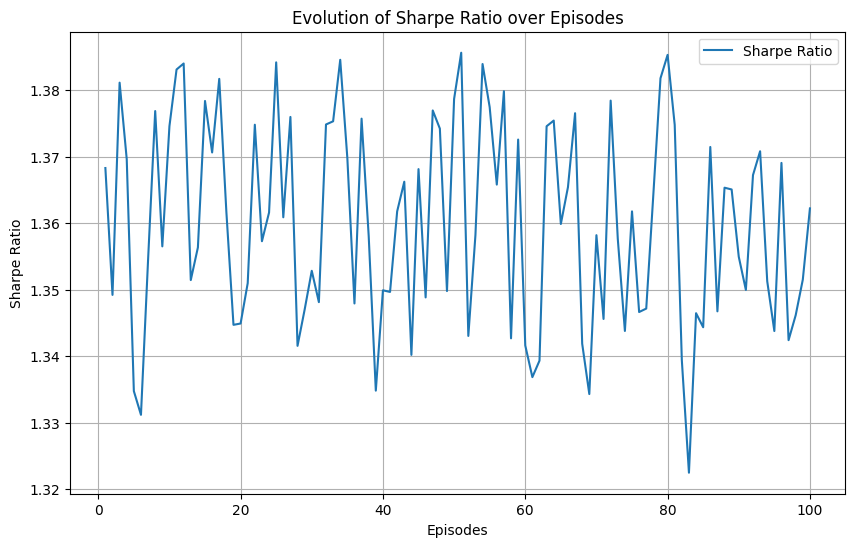

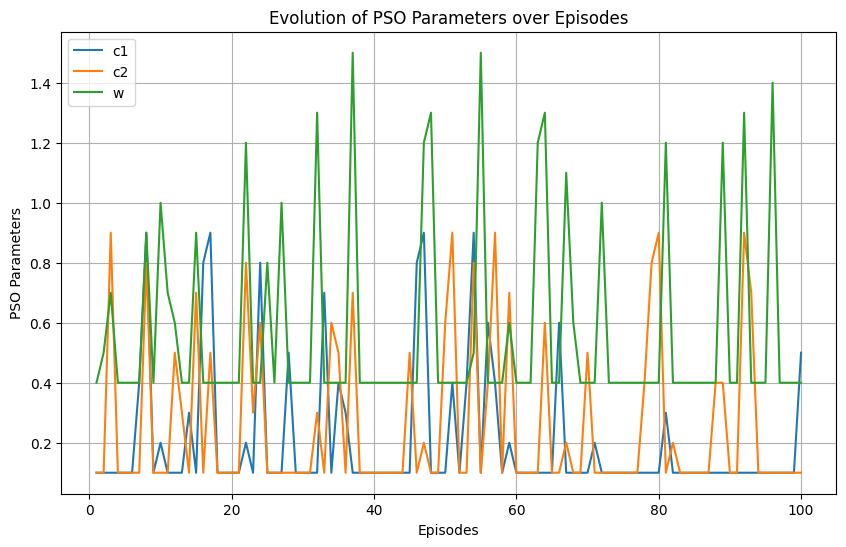

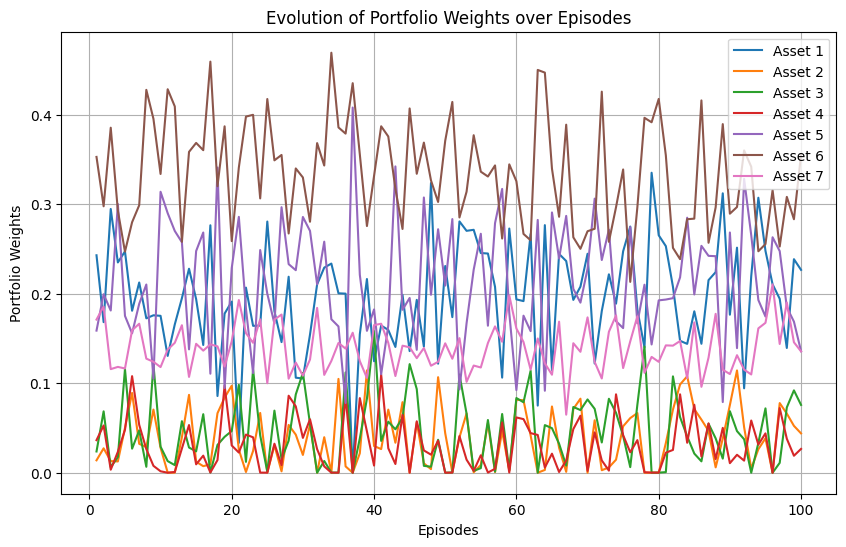

In [9]:

# Imprimir la mejor configuración al final
print("Best Sharpe Ratio:", best_sharpe_ratio)
print("Best Portfolio Weights:", best_portfolio_weights)
print("Best PSO Parameters:", best_pso_params)

# Graficar el Sharpe Ratio a lo largo de los episodios
plt.figure(figsize=(10, 6))
plt.plot(episodes, sharpe_ratios, label='Sharpe Ratio')
plt.xlabel('Episodes')
plt.ylabel('Sharpe Ratio')
plt.title('Evolution of Sharpe Ratio over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los parámetros PSO a lo largo de los episodios
plt.figure(figsize=(10, 6))
plt.plot(episodes, c1_values, label='c1')
plt.plot(episodes, c2_values, label='c2')
plt.plot(episodes, w_values, label='w')
plt.xlabel('Episodes')
plt.ylabel('PSO Parameters')
plt.title('Evolution of PSO Parameters over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las ponderaciones del portafolio a lo largo de los episodios
plt.figure(figsize=(10, 6))
for i in range(num_assets):
    plt.plot(episodes, portfolio_weights[:, i], label=f'Asset {i+1}')
plt.xlabel('Episodes')
plt.ylabel('Portfolio Weights')
plt.title('Evolution of Portfolio Weights over Episodes')
plt.legend()
plt.grid(True)
plt.show()
